In [13]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from pathlib import Path
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [14]:
def dbPath() -> Path:
    cwd = Path.cwd()
    dc2 = cwd.parent
    db = dc2.joinpath("data/database_final.db")
    return db

In [15]:
def modelPath(lsoaCode:str) ->Path:
    cwd = Path.cwd()
    dc2 = cwd.parent
    modelPath = dc2.joinpath(f"data/models/{lsoaCode}.bin")
    return modelPath

In [16]:
conn = sqlite3.connect(dbPath())

In [17]:
query_lsoa_codes = "SELECT geogcode FROM lsoa_code_to_name"
lsoa_codes = pd.read_sql(query_lsoa_codes, conn)


In [18]:
query_unemployement = "SELECT * FROM montly_unemployement_claimant_count_by_lsoa_barnet"
unemployement = pd.read_sql(query_unemployement, conn)
unemployement.dropna(inplace=True)
unemployement.drop(columns="index", inplace=True)
unemployement = unemployement[(unemployement["date"]<"2020") & (unemployement["date"]>"2012")]


In [19]:
df = pd.DataFrame(columns=lsoa_codes["geogcode"].to_list(), index=unemployement["date"].unique())
for row in tqdm(unemployement.index):
    df[unemployement["geogcode"][row]][unemployement["date"][row]] = unemployement["value"][row]

for code in tqdm(lsoa_codes["geogcode"].to_list()):
    for i in range(12):
        df[f"{code}_shift_{i+1}"] = df[f"{code}"].shift(i+1)

  0%|          | 0/17808 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

/tmp/ipykernel_7886/2313649989.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{code}_shift_{i+1}"] = df[f"{code}"].shift(i+1)
/tmp/ipykernel_7886/2313649989.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{code}_shift_{i+1}"] = df[f"{code}"].shift(i+1)
/tmp/ipykernel_7886/2313649989.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a

In [26]:
mseDct = {}
modelDct = {}
df = df.dropna()
for col in tqdm(lsoa_codes["geogcode"].to_list()):
    y = df[col].copy()
    x = df.drop(col, axis=1).copy()
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    model = xgb.XGBRegressor()
    # dmx_x_train = xgb.DMatrix(X_train.values)
    # dmx_x_test= xgb.DMatrix(X_test.values)
    # dmx_y_train= xgb.DMatrix(y_train.values)
    # dmx_y_test= xgb.DMatrix(y_test.values)
    model.fit(X_train.values, y_train)
    y_pred = model.predict(X_test.values)
    mseDct[col] = mean_squared_error(y_test, y_pred)
    model.save_model( modelPath(col))

  0%|          | 0/212 [00:00<?, ?it/s]

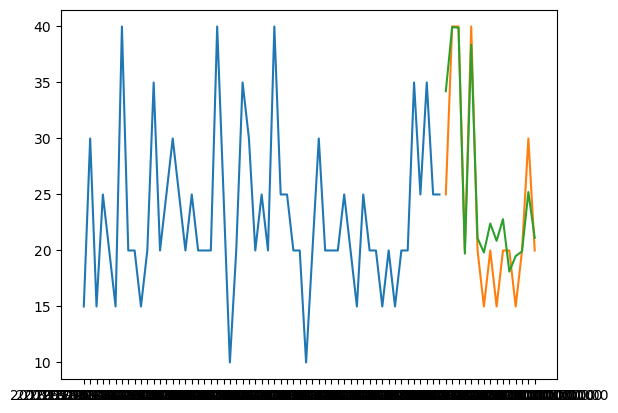

In [27]:
fig, ax = plt.subplots()
ax.plot(y_train.index, y_train)
ax.plot(y_test.index, y_test)
ax.plot(y_test.index, y_pred)

In [28]:
mseDct

{'Column Total': 68899.79833602905,
 'E01000115': 4.110286397316561,
 'E01000116': 4.790698532146295,
 'E01000117': 8.998934730203109,
 'E01000118': 10.95561982166449,
 'E01000119': 18.4901762068514,
 'E01000120': 7.327009995607356,
 'E01000121': 14.855943072641821,
 'E01000122': 7.773633725249662,
 'E01000123': 2.445693604479978,
 'E01000124': 18.67690318583409,
 'E01000125': 18.8502307954579,
 'E01000126': 40.863687645898125,
 'E01000127': 12.09063478071427,
 'E01000128': 10.745181073799237,
 'E01000129': 3.561522812548113,
 'E01000130': 34.79198589995528,
 'E01000131': 21.100309787558338,
 'E01000132': 7.512277570003547,
 'E01000133': 5.8972180420799605,
 'E01000134': 7.6552639951825165,
 'E01000135': 9.788373764932173,
 'E01000136': 10.323373551542732,
 'E01000137': 15.323743276243476,
 'E01000138': 29.519909808524243,
 'E01000139': 10.41751549848565,
 'E01000140': 12.434259708439397,
 'E01000141': 29.03677237244968,
 'E01000142': 13.302182597503997,
 'E01000143': 14.55954365400272